In [1]:
import numpy as np
import pandas as pd
import bootcampviztools as bt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression                     # Requiere Standardization
from sklearn.ensemble import RandomForestClassifier                     # Randomforest usa múltiples árboles para promediar las predicciones, reduciéndo la varianza
from catboost import CatBoostClassifier                                 # Muy potente con categóricas
from lightgbm import LGBMClassifier                                     # Se destaca por su capacidad para manejar grandes conjuntos de datos y su soporte para optimización en paralelo.
from xgboost import XGBClassifier                                       # Alta precision y rendimiento. Incorpora regularización

In [2]:
df = pd.read_excel("./datos/deals2024.xlsx")

In [3]:
df.head()

,ID asociado a venta,Persona - ID,País,Códigos promocionales utilizados en la venta,Tienda asociada a la venta,Productos comprados,Fecha de la venta,ventas asociadas al cliente,total pagado
0,6817080387,727988,España,NaN,68,"Funda Ultra suave para iPhone 14,Protector de ...",2024-01-12 07:37:14,2,19.99
1,11519078527,750466,España,NaN,115,Power Bank compatible con Magsafe 10000 mAh - ...,2024-01-17 09:10:33,2,102.54
2,118232013601,750751,España,NaN,118,"Funda EcoCase - Biodegradable para iPhone 13,C...",2024-01-17 09:11:50,2,27.77
3,12819095095,750857,España,NaN,128,Funda Bumper Ultra Suave para Samsung Galaxy A...,2024-01-17 09:13:35,2,38.76
4,16619048201,740049,España,NaN,166,Cristal Templado Completo Irrompible para iPho...,2024-01-17 09:39:33,2,83.74


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81937 entries, 0 to 81936
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   ID asociado a venta                            81937 non-null  int64  
 1   Persona - ID                                   81937 non-null  int64  
 2   País                                           81937 non-null  object 
 3    Códigos promocionales utilizados en la venta  58867 non-null  object 
 4   Tienda asociada a la venta                     81937 non-null  int64  
 5   Productos comprados                            81653 non-null  object 
 6   Fecha de la venta                              81937 non-null  object 
 7   ventas asociadas al cliente                    81937 non-null  int64  
 8   total pagado                                   81937 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.

In [5]:
def get_cardinality(df:pd.DataFrame, threshold_categorical=10, threshold_continuous=30):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    print('pandas.DataFrame shape: ', df.shape)
    
    df_out = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.isna().sum(), df.dtypes])
    df_out = df_out.T.rename(columns = {0: 'Cardinality', 1: '%_Card', 2: 'NaN_Values', 3: 'Type'})
    
    df_out.loc[df_out['Cardinality'] < threshold_categorical, 'Class'] = 'Categoric'    
    df_out.loc[df_out['Cardinality'] == 2, 'Class'] = 'Binary'
    df_out.loc[df_out['Cardinality'] >= threshold_categorical, 'Class'] ='Numeric - Discrete'
    df_out.loc[df_out['%_Card'] > threshold_continuous, 'Class'] = 'Numeric - Continuous'
    
    return df_out


In [6]:
get_cardinality(df)

pandas.DataFrame shape:  (81937, 9)


,Cardinality,%_Card,NaN_Values,Type,Class
ID asociado a venta,75127,91.688736,0,int64,Numeric - Continuous
Persona - ID,37893,46.246506,0,int64,Numeric - Continuous
País,1,0.00122,0,object,Categoric
Códigos promocionales utilizados en la venta,3030,3.697963,23070,object,Numeric - Discrete
Tienda asociada a la venta,271,0.330742,0,int64,Numeric - Discrete
Productos comprados,47571,58.05802,284,object,Numeric - Continuous
Fecha de la venta,80601,98.369479,0,object,Numeric - Continuous
ventas asociadas al cliente,34,0.041495,0,int64,Numeric - Discrete
total pagado,3529,4.306968,0,float64,Numeric - Discrete


In [7]:
df.rename(columns={'ID asociado a venta ':'id_venta',
                   'Persona - ID':'id_persona',
                   ' Códigos promocionales utilizados en la venta': 'promocion',
                   'Tienda asociada a la venta': 'codigo_tienda',
                   'ventas asociadas al cliente ':'num_ventas',
                   'Productos comprados ':'productos',
                   'Fecha de la venta':'fecha',
                   'total pagado':'precio'}, inplace=True)

In [8]:
df.id_venta.nunique()

75127

VAMOS A LIMPIAR FILAS

In [9]:
df.head()

,id_venta,id_persona,País,promocion,codigo_tienda,productos,fecha,num_ventas,precio
0,6817080387,727988,España,NaN,68,"Funda Ultra suave para iPhone 14,Protector de ...",2024-01-12 07:37:14,2,19.99
1,11519078527,750466,España,NaN,115,Power Bank compatible con Magsafe 10000 mAh - ...,2024-01-17 09:10:33,2,102.54
2,118232013601,750751,España,NaN,118,"Funda EcoCase - Biodegradable para iPhone 13,C...",2024-01-17 09:11:50,2,27.77
3,12819095095,750857,España,NaN,128,Funda Bumper Ultra Suave para Samsung Galaxy A...,2024-01-17 09:13:35,2,38.76
4,16619048201,740049,España,NaN,166,Cristal Templado Completo Irrompible para iPho...,2024-01-17 09:39:33,2,83.74


COLUMNA ID_VENTA

Vamos a examinar la columna id_venta, ya que en prinicpio cada valor debería ser único

In [10]:
conteo_repetidos = df['id_venta'].value_counts()[df['id_venta'].value_counts() > 1]
conteo_repetidos

id_venta
0               7
3451008573      3
351230011274    3
32822010247     3
6917152299      3
               ..
161221022637    2
16619052514     2
16719092978     2
19220068793     2
26621050104     2
Name: count, Length: 6801, dtype: int64

Hay muchos id_venta duplicados

In [11]:
resultado = df[df['id_venta'] == 3451008573]
resultado

,id_venta,id_persona,País,promocion,codigo_tienda,productos,fecha,num_ventas,precio
11387,3451008573,1114795,España,NaN,345,NaN,2024-07-02 14:09:20,3,0.00
14252,3451008573,1114795,España,NPP:Club5,345,BUMPER LEATHER XIAOMI RN10/REDMI NT10,2024-07-18 03:35:43,3,12.99
14373,3451008573,1114795,España,NPP:Club5,345,BUMPER LEATHER XIAOMI RN10/REDMI NT10,2024-07-18 03:47:18,3,12.99


Por lo pronto tenemos filas duplicadas, eliminamos los duplicados\
La fila que conservaremos será la que tenga el valor más alto en la columna "precio". Si todos los valores de "precio" son iguales, entonces nos quedaremos con la primera fila encontrada 

In [12]:
df = df.loc[df.groupby('id_venta')['precio'].idxmax()]

In [13]:
resultado = df[df['id_venta'] == 3451008573]
resultado

,id_venta,id_persona,País,promocion,codigo_tienda,productos,fecha,num_ventas,precio
14252,3451008573,1114795,España,NPP:Club5,345,BUMPER LEATHER XIAOMI RN10/REDMI NT10,2024-07-18 03:35:43,3,12.99


In [14]:
df['id_venta'].value_counts()

id_venta
0                1
62203071230      1
62203071483      1
62203071471      1
62203071446      1
                ..
16419063138      1
16419063132      1
16419063113      1
16419063092      1
3642400003082    1
Name: count, Length: 75127, dtype: int64

Ya no hay filas repetidas por id_venta. Como la columna en sí no aporta nada, la eliminamos

In [15]:
df = df.drop(["id_venta"], axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75127 entries, 11773 to 78124
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_persona     75127 non-null  int64  
 1   País           75127 non-null  object 
 2   promocion      54107 non-null  object 
 3   codigo_tienda  75127 non-null  int64  
 4   productos      74887 non-null  object 
 5   fecha          75127 non-null  object 
 6   num_ventas     75127 non-null  int64  
 7   precio         75127 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 5.2+ MB


AHORA VAMOS CON ID_PERSONA

In [17]:
df_sorted = df.sort_values(by="id_persona", ascending=True)
df_sorted.head()

,id_persona,País,promocion,codigo_tienda,productos,fecha,num_ventas,precio
689,723543,España,NaN,323,Pack de imanes para móvil - Soporte de móvil,2024-02-08 06:52:05,2,1.99
50552,723543,España,NaN,118,ADAPTACIÓN DE COLGANTE ACCESORIOS ADAP/COLGANT...,2024-08-24 15:59:10,2,4.98
63267,727451,España,NPP:Club5,345,BUMPER APPLE WATCH 360 ACCESORIOS 40APPLE WATCH,2024-09-12 04:29:41,5,9.99
49100,727451,España,NPP:Club5,345,ENCHUFE CARGADOR ACCESORIOS PD25,2024-08-23 02:44:37,5,19.99
57210,727451,España,"NPP:Club5,NPP:Club5",345,Lanyard estampado Boho - Colgante para Móvil y...,2024-09-04 23:19:14,5,14.98


Habrá que hacer transformaciones, pero antes hay que tocar otras columnas así que lo dejamos para más adelante

COLUMNA PAÍS\
Siempre es el mismo valor, la borramos

In [18]:
df.País.value_counts()

País
España    75127
Name: count, dtype: int64

In [19]:
df = df.drop(["País"], axis=1)
df.head()

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio
11773,1110233,NaN,308,"Pulverizador de Pantallas,Cubre Objetivo Fluor...",2024-07-17 19:04:51,2,93.91
8418,1066609,NPP:Club5,238,SOPORTE ACCESORIOS VENT,2024-06-25 03:03:45,2,0.01
8596,1069011,NaN,238,"FUNDA IMD PREMIUM APPLE I14P,SOPORTE ACCESORIO...",2024-06-25 07:28:06,2,22.97
14856,1116675,NaN,238,"Pulsera Brillos para Móvil - Night Collection,...",2024-07-18 07:18:04,2,11.98
25403,1237721,NaN,238,"Funda Ultra suave para iPhone 12,Protector de ...",2024-08-01 05:31:56,2,30.97


COLUMNA PROMOCIÓN\
Habrá que hacer algunas transformaciones con los NaN, lo dejamos para más adelante

COLUMNA 'PRODUCTOS'

In [20]:
df[(df['productos'].isnull())]

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio
61205,859351,NaN,29,NaN,2024-09-09 17:58:28,2,0.00
5368,975815,NaN,26,NaN,2024-03-26 21:35:21,2,12.99
61156,853222,NaN,34,NaN,2024-09-09 17:54:18,2,0.00
61179,857129,NaN,34,NaN,2024-09-09 17:56:07,2,0.00
19105,1160834,"NPP:Club5,NPP:Club5,NPP:Club5",34,NaN,2024-07-23 14:47:26,2,0.00
...,...,...,...,...,...,...,...
61165,846595,NaN,357,NaN,2024-09-09 17:55:17,7,0.00
61178,835571,NaN,357,NaN,2024-09-09 17:56:07,5,0.00
61187,857859,NaN,357,NaN,2024-09-09 17:56:20,3,0.00
19104,1160809,NPP:Club5,502,NaN,2024-07-23 14:45:17,2,0.00


In [21]:
df['productos'] = df['productos'].fillna('desconocido')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75127 entries, 11773 to 78124
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_persona     75127 non-null  int64  
 1   promocion      54107 non-null  object 
 2   codigo_tienda  75127 non-null  int64  
 3   productos      75127 non-null  object 
 4   fecha          75127 non-null  object 
 5   num_ventas     75127 non-null  int64  
 6   precio         75127 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 4.6+ MB


Ya no hay nulos en 'productos'

In [23]:
df.head()

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio
11773,1110233,NaN,308,"Pulverizador de Pantallas,Cubre Objetivo Fluor...",2024-07-17 19:04:51,2,93.91
8418,1066609,NPP:Club5,238,SOPORTE ACCESORIOS VENT,2024-06-25 03:03:45,2,0.01
8596,1069011,NaN,238,"FUNDA IMD PREMIUM APPLE I14P,SOPORTE ACCESORIO...",2024-06-25 07:28:06,2,22.97
14856,1116675,NaN,238,"Pulsera Brillos para Móvil - Night Collection,...",2024-07-18 07:18:04,2,11.98
25403,1237721,NaN,238,"Funda Ultra suave para iPhone 12,Protector de ...",2024-08-01 05:31:56,2,30.97


Hay que tratar los valores, lo dejamos para más adelante

EXAMINAMOS LAS VENTAS SIN PRODUCTOS
Parece que tenemos varias ventas 'fake', sin ningún producto y con valor 0

In [24]:
df[(df['productos'].isnull()) & (df['precio'] == 0)]

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio


Las eliminamos

In [25]:
df = df[df['precio'] != 0]

Vamos a revisar las devoluciones para quitarlas del dataframe

In [26]:
df[df['precio'] < 0]

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio
346,746688,NaN,29,Funda Glossy Shiny para Samsung Galaxy A52 5G,2024-01-26 23:33:51,2,-16.99
43868,1337050,NaN,39,FLIP COVER PREM TABLET I234/IPAD 2/3/4,2024-08-13 02:48:46,3,-24.99
74009,1550367,NaN,41,Auriculares Inalámbricos Nueva Generación,2024-09-26 07:29:27,3,-15.00
37839,1253497,NaN,26,FILM TRASERO CRISTAL TEMPLADO GENE,2024-08-05 07:45:02,4,-7.99
41065,1286293,NaN,28,"Funda Ultra suave para Xiaomi 14,CORDON PREMIU...",2024-08-09 10:48:03,3,-22.98
...,...,...,...,...,...,...,...
46124,1349680,PPV,291,Cargador Magnético para coche,2024-08-17 05:20:04,2,-34.99
46414,1352384,NaN,291,Colgante Premium de Diseño Metálicos para móviles,2024-08-17 11:18:12,2,-7.99
50297,1372084,NaN,291,Cristal Templado Completo para Xiaomi Poco X4 GT,2024-08-24 10:59:15,3,-12.99
51869,1393531,PPV,291,Cristal Templado Completo Irrompible para Sams...,2024-08-26 02:35:54,3,-19.99


In [27]:
df = df[df['precio'] > 0]

AHORA SÍ VAMOS CON LAS TRANSFORMACIONES

In [28]:
df.head()

,id_persona,promocion,codigo_tienda,productos,fecha,num_ventas,precio
11773,1110233,NaN,308,"Pulverizador de Pantallas,Cubre Objetivo Fluor...",2024-07-17 19:04:51,2,93.91
8418,1066609,NPP:Club5,238,SOPORTE ACCESORIOS VENT,2024-06-25 03:03:45,2,0.01
8596,1069011,NaN,238,"FUNDA IMD PREMIUM APPLE I14P,SOPORTE ACCESORIO...",2024-06-25 07:28:06,2,22.97
14856,1116675,NaN,238,"Pulsera Brillos para Móvil - Night Collection,...",2024-07-18 07:18:04,2,11.98
25403,1237721,NaN,238,"Funda Ultra suave para iPhone 12,Protector de ...",2024-08-01 05:31:56,2,30.97


In [29]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, stratify = df['num_ventas'], random_state=42)  

COLUMNA PROMOCION\
Transformamos a numéricos los valores de la columna promocion, y le cambiamos el nombre a num_promociones

In [30]:
train_set.promocion.value_counts()

promocion
NPP:Club5                                                                                    10572
NPP:Club5,NPP:Club5                                                                           7275
NPP:Club5,NPP:Club5,NPP:Club5                                                                 3904
NPP:Club5,NPP:Club5,NPP:Club5,NPP:Club5                                                       1532
NPP:FILM TRASERO 20%                                                                           610
                                                                                             ...  
NPP:Club5,NPP:Club5,NPP:Club5,NPP:Club5,NPP:Club5,NPP:COLG50ES,NPP:Club5                         1
PPG 3x2 *,NPP:Club5,PPG 3x2 *,PPG 3x2 *,PPG 3x2 *,NPP:Club5,PPG 3x2 *,PPG 3x2 *,%D x 2U          1
NPP:Club5,PRINCIPADO10,NPP:Club5,PRINCIPADO10,NPP:FILM TRASERO 20%,NPP:Club5,PRINCIPADO10        1
%D x V,%D x V,%D x V,NPP:Club5,CLUB5,NPP:Club5,CLUB5                                             1


In [31]:
train_set['promocion'] = train_set['promocion'].str.split(',').str.len()
train_set.rename(columns={'promocion':'num_promociones'}, inplace=True)

test_set['promocion'] = test_set['promocion'].str.split(',').str.len()
test_set.rename(columns={'promocion':'num_promociones'}, inplace=True)

In [32]:
train_set.head()

,id_persona,num_promociones,codigo_tienda,productos,fecha,num_ventas,precio
19343,1163718,NaN,146,Cristal Templado Completo para Xiaomi Redmi 12...,2024-07-24 02:08:02,2,25.97
3034,948191,NaN,44,"Pulsera Brillos para Móvil - Night Collection,...",2024-03-11 03:33:38,6,49.96
18956,1159086,2.0,106,"CUBRE OBJETIVO LUM ACCESORIOS 12MX/IP12 PR MX,...",2024-07-23 11:03:34,2,8.98
73236,1482051,1.0,193,COLGANTE MUÑECA ACCESORIOS MULT,2024-09-24 14:19:06,2,3.99
71378,1167653,12.0,306,"SMARTWATCH PRO ACCESORIOS SMPR,COLGANTE CUELL...",2024-09-21 11:52:05,3,91.95


Quedan nulos, convertimos en 0 todos los valores nulos de num_promociones

In [33]:
train_set['num_promociones'] = train_set['num_promociones'].fillna(0)
test_set['num_promociones'] = test_set['num_promociones'].fillna(0)


In [34]:
train_set.num_promociones.value_counts()

num_promociones
0.0     15851
1.0     14451
2.0     10364
3.0      7024
4.0      4694
5.0      2108
6.0      1607
7.0       650
8.0       473
9.0       198
10.0      167
11.0       85
12.0       49
13.0       25
14.0       24
15.0       20
16.0       15
18.0       11
17.0       10
19.0        3
22.0        3
24.0        2
33.0        1
21.0        1
65.0        1
20.0        1
Name: count, dtype: int64

In [35]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57838 entries, 19343 to 77276
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_persona       57838 non-null  int64  
 1   num_promociones  57838 non-null  float64
 2   codigo_tienda    57838 non-null  int64  
 3   productos        57838 non-null  object 
 4   fecha            57838 non-null  object 
 5   num_ventas       57838 non-null  int64  
 6   precio           57838 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.5+ MB


In [36]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14460 entries, 12640 to 28859
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_persona       14460 non-null  int64  
 1   num_promociones  14460 non-null  float64
 2   codigo_tienda    14460 non-null  int64  
 3   productos        14460 non-null  object 
 4   fecha            14460 non-null  object 
 5   num_ventas       14460 non-null  int64  
 6   precio           14460 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 903.8+ KB


Ya no hay nulos en 'num_promociomes'

COLUMNA PRODUCTOS\
Lo convertimos a nº de productos comprados

In [37]:
train_set.head()

,id_persona,num_promociones,codigo_tienda,productos,fecha,num_ventas,precio
19343,1163718,0.0,146,Cristal Templado Completo para Xiaomi Redmi 12...,2024-07-24 02:08:02,2,25.97
3034,948191,0.0,44,"Pulsera Brillos para Móvil - Night Collection,...",2024-03-11 03:33:38,6,49.96
18956,1159086,2.0,106,"CUBRE OBJETIVO LUM ACCESORIOS 12MX/IP12 PR MX,...",2024-07-23 11:03:34,2,8.98
73236,1482051,1.0,193,COLGANTE MUÑECA ACCESORIOS MULT,2024-09-24 14:19:06,2,3.99
71378,1167653,12.0,306,"SMARTWATCH PRO ACCESORIOS SMPR,COLGANTE CUELL...",2024-09-21 11:52:05,3,91.95


In [38]:
train_set['num_productos'] = train_set['productos'].str.split(',').str.len()
train_set = train_set.drop(["productos"], axis=1)

test_set['num_productos'] = test_set['productos'].str.split(',').str.len()
test_set = test_set.drop(["productos"], axis=1)

In [39]:
train_set.num_productos.value_counts()

num_productos
1     19276
2     15586
3     10505
4      6004
5      3025
6      1630
7       813
8       459
9       220
10      132
11       65
12       42
13       27
14       17
15       14
18        8
19        4
16        4
21        2
33        1
17        1
25        1
65        1
22        1
Name: count, dtype: int64

In [40]:
train_set.head()

,id_persona,num_promociones,codigo_tienda,fecha,num_ventas,precio,num_productos
19343,1163718,0.0,146,2024-07-24 02:08:02,2,25.97,3
3034,948191,0.0,44,2024-03-11 03:33:38,6,49.96,4
18956,1159086,2.0,106,2024-07-23 11:03:34,2,8.98,2
73236,1482051,1.0,193,2024-09-24 14:19:06,2,3.99,1
71378,1167653,12.0,306,2024-09-21 11:52:05,3,91.95,7


COLUMNA FECHA\
Solo nos interesa el mes de la venta, ya que la fecha siempre va a ser diferente

In [41]:
'''train_set['mes'] = pd.to_datetime(train_set['fecha']).dt.month
test_set['mes'] = pd.to_datetime(test_set['fecha']).dt.month'''

"train_set['mes'] = pd.to_datetime(train_set['fecha']).dt.month\ntest_set['mes'] = pd.to_datetime(test_set['fecha']).dt.month"

Como es categórica (nº del mes) aplicamos ONe-Hot-Encoding

In [42]:
# Asegurarnos de que la columna de fechas esté en formato datetime
train_set['fecha'] = pd.to_datetime(train_set['fecha'])
test_set['fecha'] = pd.to_datetime(test_set['fecha'])

# Extraemos el mes de la fecha
train_set['mes'] = train_set['fecha'].dt.month
test_set['mes'] = test_set['fecha'].dt.month

# Aplicamos One-Hot Encoding
train_set = pd.get_dummies(train_set, columns=['mes'], prefix='mes', drop_first=False, dtype=int)
test_set = pd.get_dummies(test_set, columns=['mes'], prefix='mes', drop_first=False, dtype=int)

# elimnimamos la columna 'fecha' anterior
train_set = train_set.drop(["fecha"], axis=1)
test_set = test_set.drop(["fecha"], axis=1)

In [43]:
train_set.head()

,id_persona,num_promociones,codigo_tienda,num_ventas,precio,num_productos,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10
19343,1163718,0.0,146,2,25.97,3,0,0,0,0,0,1,0,0,0
3034,948191,0.0,44,6,49.96,4,0,0,1,0,0,0,0,0,0
18956,1159086,2.0,106,2,8.98,2,0,0,0,0,0,1,0,0,0
73236,1482051,1.0,193,2,3.99,1,0,0,0,0,0,0,0,1,0
71378,1167653,12.0,306,3,91.95,7,0,0,0,0,0,0,0,1,0


COLUMNA NUM_VENTAS\
Creamos nueva columna num_ventas_target que será el target\
Creamos categorías

In [44]:
# TRAIN
# Condiciones para cada clasificación
condiciones = [
    train_set['num_ventas'] == 2,
    train_set['num_ventas'] >= 3]

# Opciones
opciones = ['Dos', 'Tres o más']

# Nueva columna
train_set['num_ventas_target'] = np.select(condiciones, opciones)


# TEST
# Condiciones para cada clasificación
condiciones = [
    test_set['num_ventas'] == 2,
    test_set['num_ventas'] >= 3]

# Opciones
opciones = ['Dos', 'Tres o más']

# Nueva columna
test_set['num_ventas_target'] = np.select(condiciones, opciones)

In [45]:
train_set = train_set.drop(["num_ventas"], axis=1)
test_set = test_set.drop(["num_ventas"], axis=1)

In [46]:
train_set.head(10)

,id_persona,num_promociones,codigo_tienda,precio,num_productos,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10,num_ventas_target
19343,1163718,0.0,146,25.97,3,0,0,0,0,0,1,0,0,0,Dos
3034,948191,0.0,44,49.96,4,0,0,1,0,0,0,0,0,0,Tres o más
18956,1159086,2.0,106,8.98,2,0,0,0,0,0,1,0,0,0,Dos
73236,1482051,1.0,193,3.99,1,0,0,0,0,0,0,0,1,0,Dos
71378,1167653,12.0,306,91.95,7,0,0,0,0,0,0,0,1,0,Tres o más
78648,1316634,2.0,79,31.98,2,0,0,0,0,0,0,0,0,1,Dos
18886,1159252,5.0,49,47.95,5,0,0,0,0,0,1,0,0,0,Dos
51909,1398098,2.0,262,14.98,2,0,0,0,0,0,0,1,0,0,Dos
49386,1366649,3.0,275,29.00,5,0,0,0,0,0,0,1,0,0,Tres o más
21722,1193725,2.0,86,11.98,2,0,0,0,0,0,1,0,0,0,Dos


Comprobamos que las categorías están bien asignadas, filtrando las filas donde 'num_ventas_target' sea igual a 'Tres o más'


In [47]:
# Filtrar las filas donde 'num_ventas_target' sea igual a 'Tres o más'
filter = train_set[train_set['num_ventas_target'] == 'Tres o más']

# Contar las ocurrencias de cada valor en 'id_persona'
counts = filter['id_persona'].value_counts()

# Obtener los valores de 'id_persona' que se repiten exactamente 2 veces
ids_with_two_occurrences = counts[counts == 2].index

# Filtrar nuevamente para incluir solo los 'id_persona' con exactamente 2 ocurrencias
result = filter[filter['id_persona'].isin(ids_with_two_occurrences)]

# Ordenar por 'id_persona' en orden ascendente
result = result.sort_values(by='id_persona', ascending=True)
result

,id_persona,num_promociones,codigo_tienda,precio,num_productos,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10,num_ventas_target
33897,730568,1.0,44,19.99,1,0,0,0,0,0,0,1,0,0,Tres o más
249,730568,0.0,44,12.99,1,1,0,0,0,0,0,0,0,0,Tres o más
257,732020,0.0,188,10.94,2,1,0,0,0,0,0,0,0,0,Tres o más
11100,732020,3.0,263,23.97,3,0,0,0,0,0,1,0,0,0,Tres o más
316,739566,0.0,146,67.98,2,1,0,0,0,0,0,0,0,0,Tres o más
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69724,1562430,3.0,248,9.00,4,0,0,0,0,0,0,0,1,0,Tres o más
80063,1562515,0.0,196,14.99,1,0,0,0,0,0,0,0,0,1,Tres o más
69689,1562515,2.0,196,36.98,2,0,0,0,0,0,0,0,1,0,Tres o más
76744,1562582,1.0,191,19.99,1,0,0,0,0,0,0,0,0,1,Tres o más


En efecto hay filas con la clase mal asignada, así que lo arreglamos

In [48]:
# Filtrar las filas donde 'num_ventas_target' sea igual a 'Tres o más'
filter_train = train_set[train_set['num_ventas_target'] == 'Tres o más']
filter_test = test_set[test_set['num_ventas_target'] == 'Tres o más']

# Contar las ocurrencias de cada valor en 'id_persona'
counts_train = filter_train['id_persona'].value_counts()
counts_test = filter_test['id_persona'].value_counts()

# Obtener los valores de 'id_persona' que se repiten exactamente 2 veces
ids_with_two_occurrences_train = counts[counts == 2].index
ids_with_two_occurrences_test = counts[counts == 2].index

# Cambiar el valor de 'num_ventas_target' a 'Dos' para estas filas
train_set.loc[(train_set['num_ventas_target'] == 'Tres o más') & (train_set['id_persona'].isin(ids_with_two_occurrences_train)), 'num_ventas_target'] = 'Dos'
test_set.loc[(test_set['num_ventas_target'] == 'Tres o más') & (test_set['id_persona'].isin(ids_with_two_occurrences_test)), 'num_ventas_target'] = 'Dos'

In [49]:
# Filtrar las filas donde 'num_ventas_target' sea igual a 'Tres o más'
filtered_df = test_set[test_set['num_ventas_target'] == 'Tres o más']

# Contar las ocurrencias de cada valor en 'id_persona'
counts = filtered_df['id_persona'].value_counts()

# Obtener los valores de 'id_persona' que se repiten exactamente 2 veces
ids_with_two_occurrences = counts[counts == 2].index

# Filtrar nuevamente para incluir solo los 'id_persona' con exactamente 2 ocurrencias
result = filtered_df[filtered_df['id_persona'].isin(ids_with_two_occurrences)]

# Ordenar por 'id_persona' en orden ascendente
result = result.sort_values(by='id_persona', ascending=True)

# Mostrar el resultado
result


,id_persona,num_promociones,codigo_tienda,precio,num_productos,mes_1,mes_2,mes_3,mes_4,mes_6,mes_7,mes_8,mes_9,mes_10,num_ventas_target
56804,745335,0.0,251,27.98,3,0,0,0,0,0,0,0,1,0,Tres o más
54215,745335,0.0,251,30.97,3,0,0,0,0,0,0,1,0,0,Tres o más
585,745870,2.0,76,19.99,3,0,1,0,0,0,0,0,0,0,Tres o más
356,745870,0.0,76,17.99,1,1,0,0,0,0,0,0,0,0,Tres o más
41210,748140,4.0,166,24.98,2,0,0,0,0,0,0,1,0,0,Tres o más
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75310,1552128,2.0,114,46.98,2,0,0,0,0,0,0,0,1,0,Tres o más
56897,1557700,4.0,106,19.98,4,0,0,0,0,0,0,0,1,0,Tres o más
76446,1557700,5.0,106,75.95,5,0,0,0,0,0,0,0,0,1,Tres o más
56920,1560558,8.0,103,57.96,4,0,0,0,0,0,0,0,1,0,Tres o más


INICIAMOS MINI EDA

In [50]:
import pandas as pd
from scipy.stats import f_oneway

# Inicializa un diccionario para guardar los resultados de ANOVA
anova_results = {}

# Itera sobre cada columna numérica en train_set
for col in train_set.select_dtypes(include='number').columns:
    # Agrupa los datos numéricos por cada categoría de la variable objetivo
    grouped_data = [group[col].values for name, group in train_set.groupby('num_ventas_target')]
    
    # Calcula el p-valor de ANOVA
    anova_results[col] = f_oneway(*grouped_data)[1]  # p-valor

# Muestra los resultados de ANOVA (p-valores)
print("Resultados de ANOVA (p-valores) para cada característica numérica:")
for feature, p_value in anova_results.items():
    print(f"{feature}: {p_value}")

Resultados de ANOVA (p-valores) para cada característica numérica:
id_persona: 3.207273810970348e-172
num_promociones: 0.0003114394406091597
codigo_tienda: 2.43288052331354e-07
precio: 3.0177788299421273e-05
num_productos: 0.40819398140581453
mes_1: 0.37634153105161605
mes_2: 0.020967355580625475
mes_3: 1.3755617033562563e-05
mes_4: 0.5504743311052608
mes_6: 0.025753000834500973
mes_7: 7.752188083633492e-12
mes_8: 6.79254558598913e-14
mes_9: 3.53803727993471e-18
mes_10: 1.0840169651547854e-40


In [51]:
target = "num_ventas_target"
features_num = ["num_promociones", "codigo_tienda", "precio"]

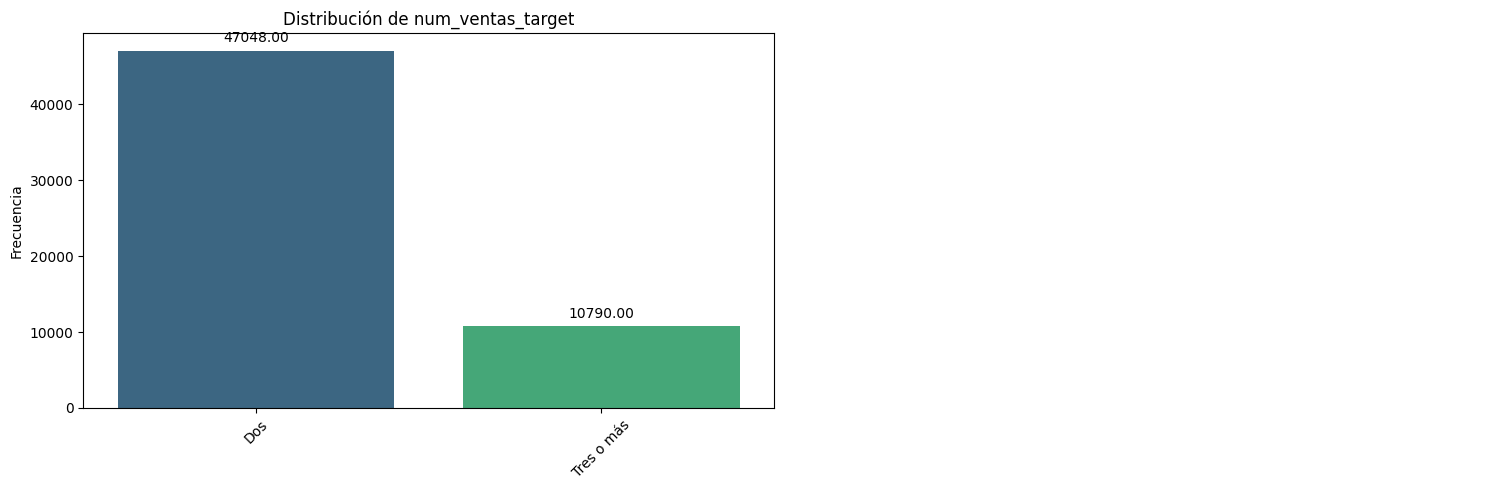

In [52]:
# Solo target
bt.pinta_distribucion_categoricas(train_set, [target], mostrar_valores = True)

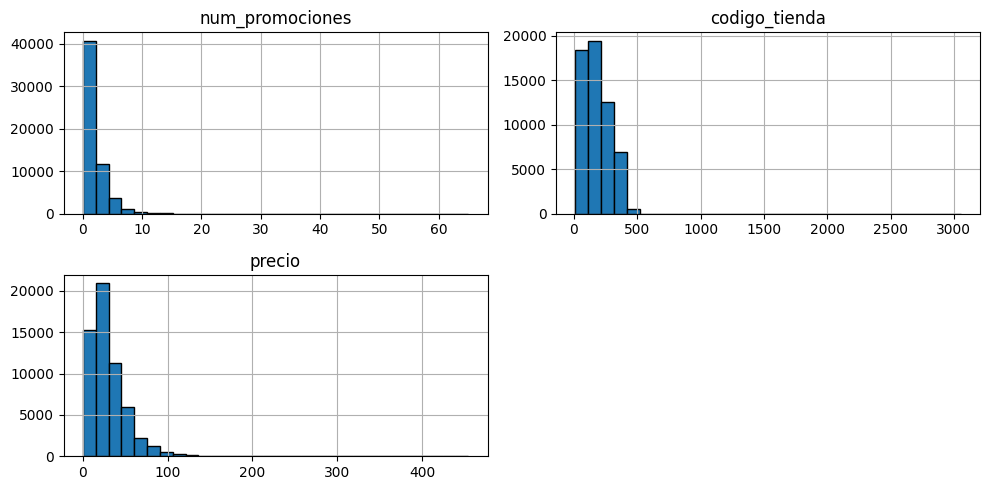

In [53]:
train_set[features_num].hist(bins=30, figsize=(10,5), edgecolor='black');
plt.tight_layout()

In [54]:
train_set_log = train_set.copy()
test_set_log = test_set.copy()

train_set_log[features_num] = train_set[features_num].apply(np.log1p)               # np.log1p(): Aplica el logaritmo natural de 1 más el valor, es más seguro cuando hay valores cercanos a cero.
test_set_log[features_num] = test_set[features_num].apply(np.log1p) 

In [55]:
scaler = StandardScaler()

train_set_scaled = train_set_log.copy()
test_set_scaled = test_set_log.copy()

train_set_scaled[features_num] = scaler.fit_transform(train_set_log[features_num])
test_set_scaled[features_num] = scaler.transform(test_set_log[features_num])

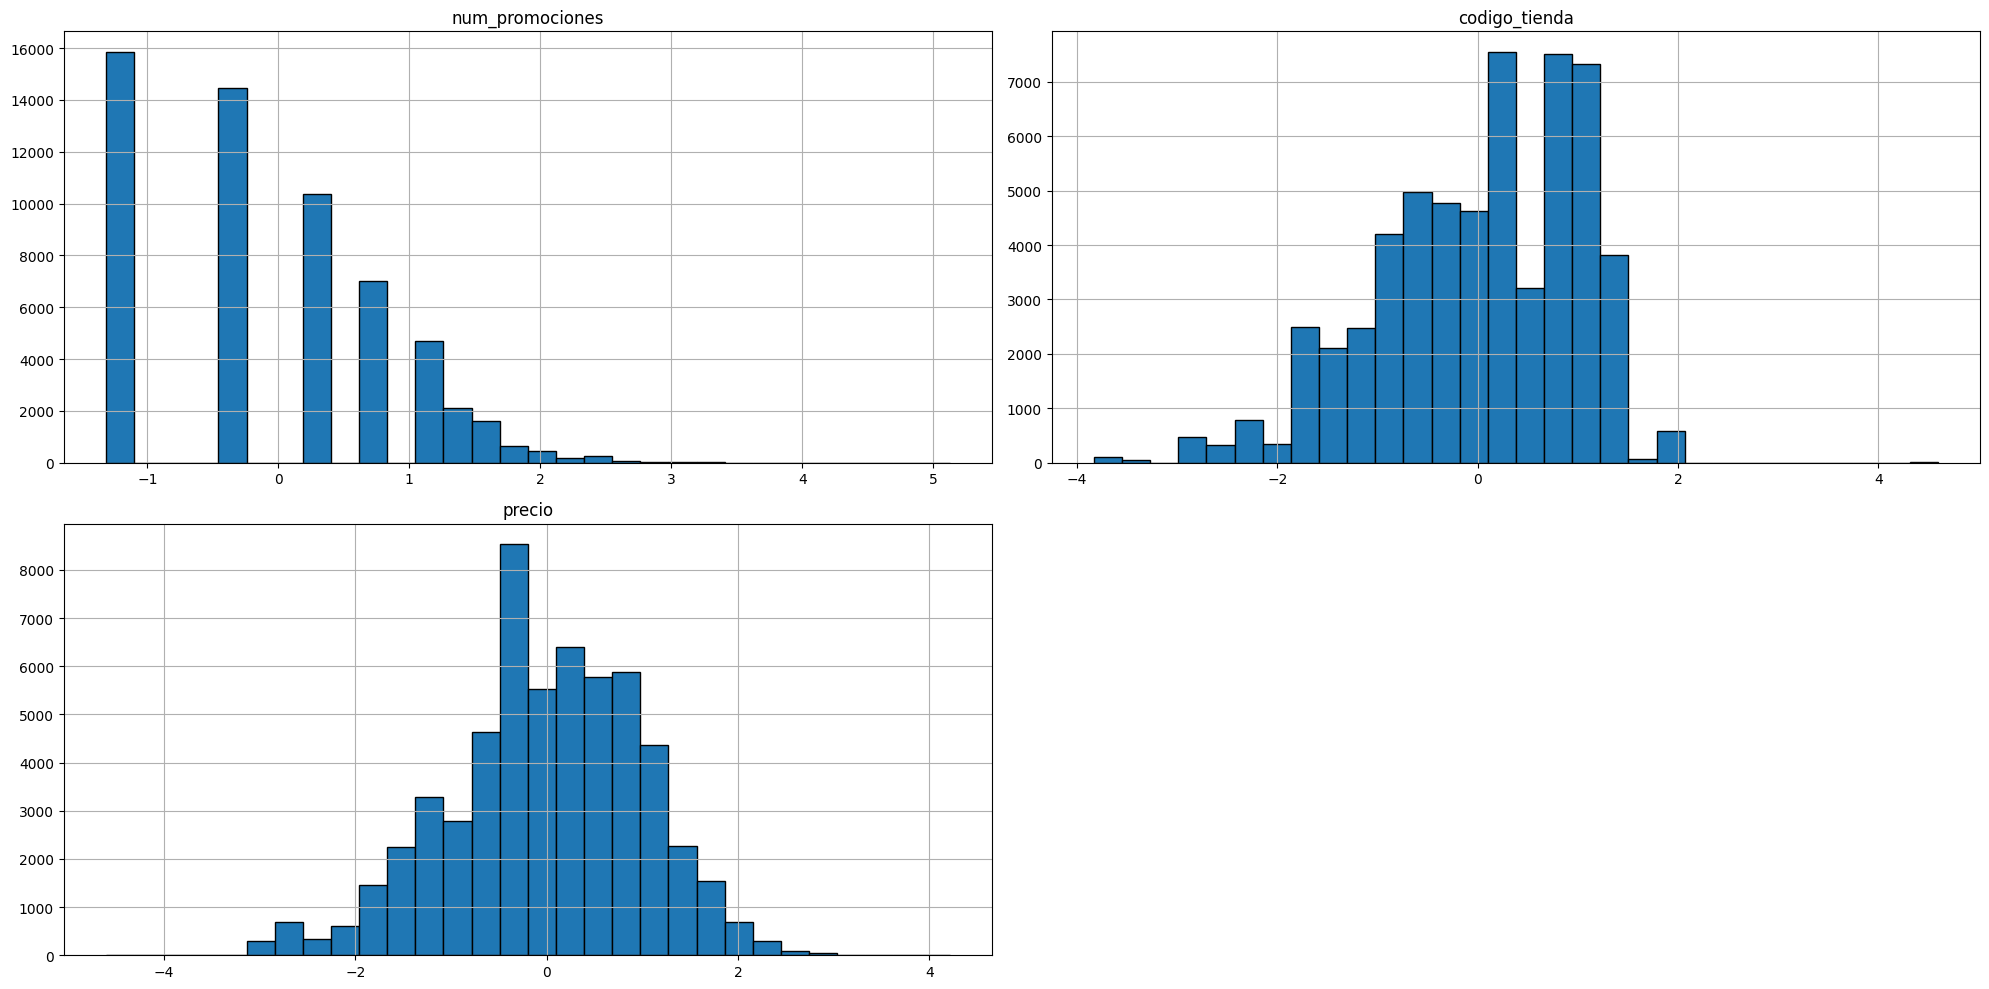

In [56]:
train_set_scal_df = pd.DataFrame(train_set_scaled[features_num])
train_set_scal_df.hist(bins=30, figsize=(20,10), edgecolor='black');
plt.tight_layout()

In [57]:
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

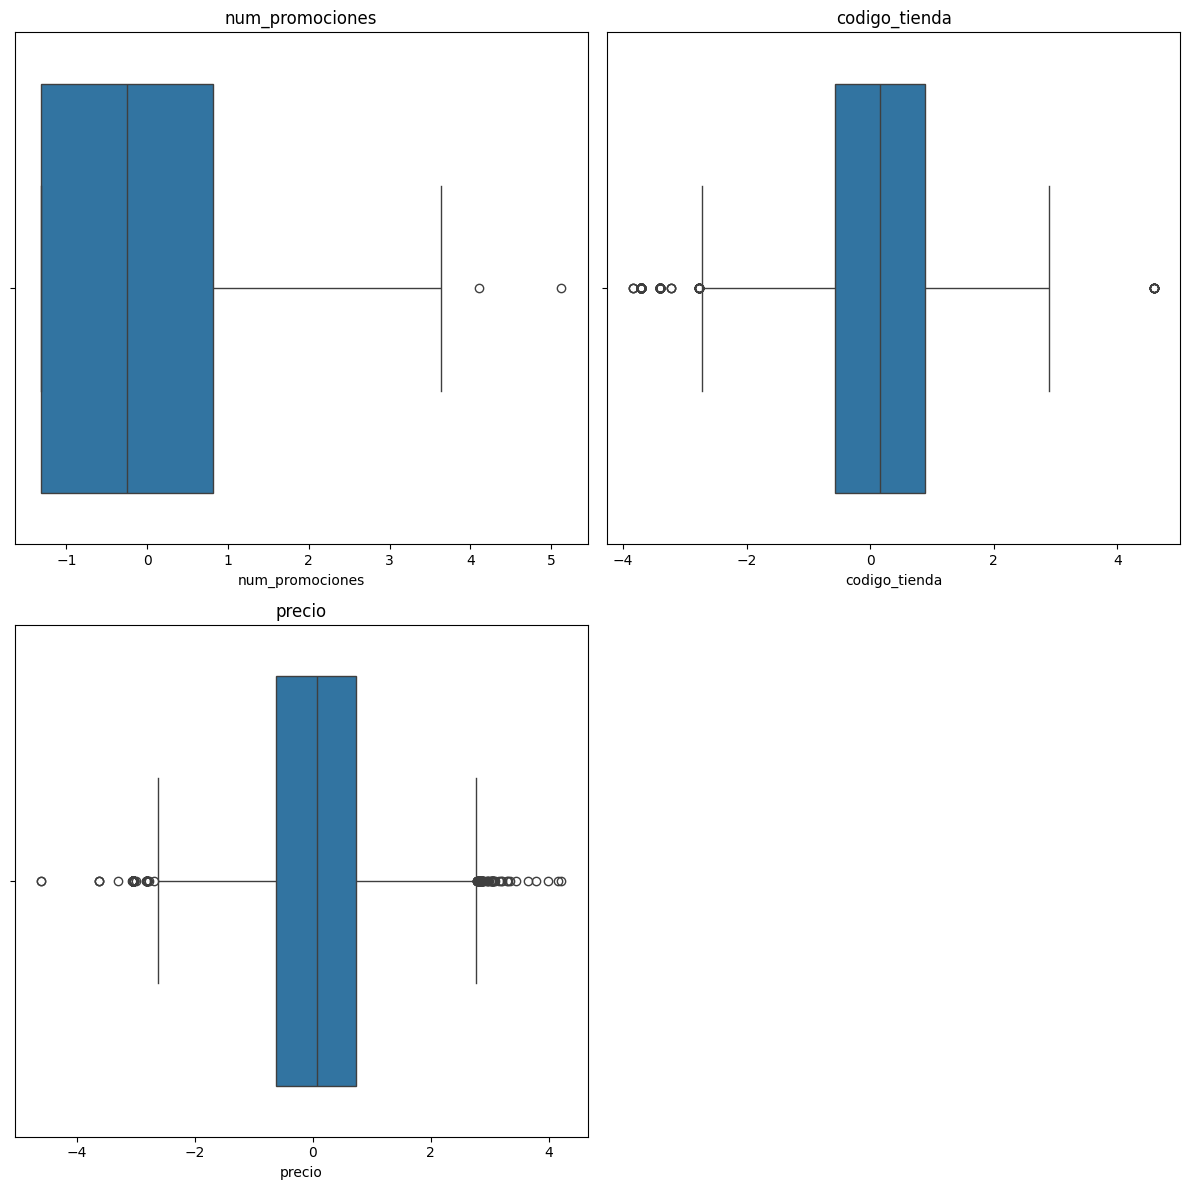

In [58]:
plot_multiple_boxplots(train_set_scaled, features_num, dim_matriz_visual = 2)

DIVIDIMOS X_TRAIN, Y_TRAIN...

In [59]:
X_train = train_set_scaled.drop([target], axis=1)
y_train = train_set_scaled[target]
X_test = test_set_scaled.drop([target], axis=1)
y_test = test_set_scaled[target]

EQUIBRAMOS EL TARGET

In [60]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print("Distribución de clases en Train después del undersampling:", pd.Series.value_counts(y_train_rus))

Distribución de clases en Train después del undersampling: num_ventas_target
Dos           10790
Tres o más    10790
Name: count, dtype: int64


In [61]:
# SMOTE (Oversampling)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribución de clases en Train después del SMOTE:", pd.Series.value_counts(y_train_smote))

Distribución de clases en Train después del SMOTE: num_ventas_target
Dos           47048
Tres o más    47048
Name: count, dtype: int64


PROBAMOS VARIOS MODELOS EN CROSS VALIDATION

In [62]:
from sklearn.model_selection import cross_val_score

modelos = ["KNN", "Logistic", "RandomF"]
metricas = []

# Instanciación de los modelos
knn_clf = KNeighborsClassifier(n_neighbors= 5, weights= "distance")
lr_clf = LogisticRegression(max_iter = 10000, class_weight= "balanced", random_state = 42)
rf_clf = RandomForestClassifier(max_depth = 10, class_weight= "balanced",random_state = 42)

# Bucle para evaluar los modelos
for nombre, modelo in zip(modelos, [knn_clf, lr_clf, rf_clf]):
    print(f"Para {nombre}:", end = " ")

    # Cross validation con métrica de regresión adecuada
    metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy")) #balanced_accuracy o recall medio

    # Imprimir la métrica
    print (metrica)

    # Añadir la métrica a la lista
    metricas.append (metrica)

Para KNN: 0.8588247533366486
Para Logistic: 0.724739916526888
Para RandomF: 0.8058389456631897


VEMOS QUÉ COMBINACIÓN DE COLUMNAS FUNCIONA MEJOR

In [63]:
'''from sklearn.metrics import accuracy_score
from itertools import combinations

def train_knn_with_combinations(X_train, y_train):
    # Lista de columnas numéricas (ya escaladas) y categóricas binarias
    num_columns = ["num_promociones", "precio", "num_productos", "codigo_tienda"]
    cat_columns = ["mes_1", "mes_2", "mes_3", "mes_4", "mes_6", "mes_7", "mes_8", "mes_9", "mes_10"]

    # Combinamos las columnas numéricas y las categóricas binarias directamente
    X_train_combined = X_train[num_columns + cat_columns]

    # Inicializamos variables para encontrar la mejor combinación
    best_comb = None
    best_accuracy = 0

    # Hacer una búsqueda exhaustiva de todas las combinaciones posibles de columnas
    for i in range(1, len(X_train_combined.columns) + 1):
        for comb in combinations(X_train_combined.columns, i):
            # Seleccionamos las columnas para el modelo
            X_train_comb = X_train_combined[list(comb)]

            # Entrenar el modelo KNN y calcular precisión usando validación cruzada
            knn = KNeighborsClassifier(n_neighbors=5)  # Ajustable
            accuracies = cross_val_score(knn, X_train_comb, y_train, cv=5, scoring='accuracy')  # Validación cruzada
            mean_accuracy = accuracies.mean()

            # Imprimir el resultado para la combinación actual
            print(f"Combinación: {comb} | Accuracy: {mean_accuracy:.4f}")

            # Actualizar la mejor combinación si se encuentra un mejor accuracy
            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_comb = comb

    # Imprimir la mejor combinación y su accuracy final
    print("\nMejor combinación encontrada:")
    print(f"Combinación: {best_comb} | Accuracy: {best_accuracy:.4f}")
    print("\nEntrenamiento completado.")

    # Devolver la mejor combinación y su precisión
    return best_comb, best_accuracy
'''

'from sklearn.metrics import accuracy_score\nfrom itertools import combinations\n\ndef train_knn_with_combinations(X_train, y_train):\n    # Lista de columnas numéricas (ya escaladas) y categóricas binarias\n    num_columns = ["num_promociones", "precio", "num_productos", "codigo_tienda"]\n    cat_columns = ["mes_1", "mes_2", "mes_3", "mes_4", "mes_6", "mes_7", "mes_8", "mes_9", "mes_10"]\n\n    # Combinamos las columnas numéricas y las categóricas binarias directamente\n    X_train_combined = X_train[num_columns + cat_columns]\n\n    # Inicializamos variables para encontrar la mejor combinación\n    best_comb = None\n    best_accuracy = 0\n\n    # Hacer una búsqueda exhaustiva de todas las combinaciones posibles de columnas\n    for i in range(1, len(X_train_combined.columns) + 1):\n        for comb in combinations(X_train_combined.columns, i):\n            # Seleccionamos las columnas para el modelo\n            X_train_comb = X_train_combined[list(comb)]\n\n            # Entrenar el

In [64]:
'''train_knn_with_combinations(X_train_smote, y_train_smote)'''

'train_knn_with_combinations(X_train_smote, y_train_smote)'

HACEMOS GRID SEARCH DEL KNN

In [65]:
# Construir el Grid o combinaciones de hiperparámetros y rangos que queremos testar
param_grid = {
    "n_neighbors": range(1,20),                         # KNN, define el número de vecinos a considerar en la clasificación
    "weights": ["uniform","distance"]}                  # KNN, cómo ponderar los vecinos

In [66]:
knn_clf = KNeighborsClassifier()

grid_models = GridSearchCV(knn_clf,
                           param_grid,
                           scoring = "balanced_accuracy") 		# Métrica que quiero optimizar (aquí balanced_accuracy o recall medio)
                                 
grid_models.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [67]:
grid_models.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [68]:
grid_models.best_score_

0.87266168496507

In [69]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights= "distance")

In [70]:
knn_clf.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [71]:
y_pred = knn_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         Dos       0.95      0.89      0.92     12085
  Tres o más       0.58      0.78      0.66      2375

    accuracy                           0.87     14460
   macro avg       0.76      0.83      0.79     14460
weighted avg       0.89      0.87      0.88     14460



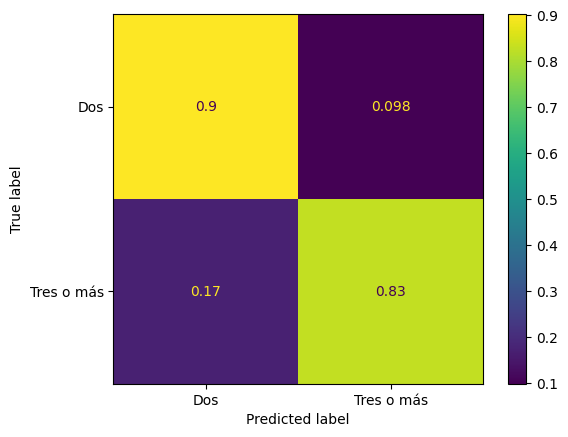

In [72]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_models.best_estimator_.predict(X_test), normalize="true")

CON PERCEPTRÓN SIMPLE

In [73]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron()
per_clf.fit(X_train_smote, y_train_smote)

Perceptron()

In [74]:
y_pred = per_clf.predict(X_test)
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         Dos       0.84      1.00      0.91     12085
  Tres o más       0.00      0.00      0.00      2375

    accuracy                           0.84     14460
   macro avg       0.42      0.50      0.46     14460
weighted avg       0.70      0.84      0.76     14460



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


MLP con Grid Search

In [75]:
'''param_grid = {
    'hidden_layer_sizes': [(50,), (50, 50), (50, 50, 50)],  # Diferentes configuraciones de las capas ocultas intermedias (1 capa de 50 neuronas, 2 capas de 50 neuronas cada una, 3 de 50)
    'activation': ['tanh', 'relu'],                         # Funciones de activación (tahn y relu)
    'solver': ['adam', 'sgd'],                              # Optimizadores que se utilizará (Adam y SGD)
    'learning_rate': ['constant', 'adaptive']               # Tasa de aprendizaje, probando tanto la tasa constante como la adaptativa (cambia según las iteraciones)
}

mlp = MLPClassifier(max_iter=1000,                        # Máximo de iteraciones o épocas. A más datos, más iteraciones harán falta.
                    batch_size = 32)                    # En general batch size de 32, 64. También 128, 256


# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=mlp,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy', n_jobs=-1)  # ,n_iter=100) - Nº de iteraciones del algoritmo

# Entrenar GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
best_mlp = grid_search.best_estimator_
test_accuracy = best_mlp.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {test_accuracy}")'''

'param_grid = {\n    \'hidden_layer_sizes\': [(50,), (50, 50), (50, 50, 50)],  # Diferentes configuraciones de las capas ocultas intermedias (1 capa de 50 neuronas, 2 capas de 50 neuronas cada una, 3 de 50)\n    \'activation\': [\'tanh\', \'relu\'],                         # Funciones de activación (tahn y relu)\n    \'solver\': [\'adam\', \'sgd\'],                              # Optimizadores que se utilizará (Adam y SGD)\n    \'learning_rate\': [\'constant\', \'adaptive\']               # Tasa de aprendizaje, probando tanto la tasa constante como la adaptativa (cambia según las iteraciones)\n}\n\nmlp = MLPClassifier(max_iter=1000,                        # Máximo de iteraciones o épocas. A más datos, más iteraciones harán falta.\n                    batch_size = 32)                    # En general batch size de 32, 64. También 128, 256\n\n\n# Configurar GridSearchCV\ngrid_search = GridSearchCV(estimator=mlp,\n                           param_grid=param_grid,\n                         

CON MLP

In [76]:
# MLP
from sklearn.neural_network import MLPClassifier # Fijate que sklearn sí que distingue entre clasificador y regresor. No tendremos que hacerlo nosotros.

'''
Por defecto viene:
 - 3 capas, con 1 sola capa oculta con 100 neuronas (más input y output)
 - Función de activación es 'relu'.
 - Batch size a "auto" = 200 instancias (lo modificamos a 32 al ser un dataset pequeño)
 - Learning rate a 0.001 y constante (usa un Adam de optimizador con momento y nesterov, ya lo trataremos con más cariño)+
 - Algunos hiperparámetros más que iremos tratando
'''
#Estandarizar con StandardScaler

mlp = MLPClassifier(hidden_layer_sizes=(100),      # Aquí habría 2 hidden layers de 100 neuronas cada una
                    max_iter=100,
                    batch_size=64,
                    early_stopping=True,
                    n_iter_no_change=10,
                    tol=1e-4,
                    random_state=42)


mlp.get_params()

mlp.fit(X_train_smote, y_train_smote)

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=100,
              max_iter=100, random_state=42)

In [77]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         Dos       0.84      1.00      0.91     12085
  Tres o más       0.00      0.00      0.00      2375

    accuracy                           0.84     14460
   macro avg       0.42      0.50      0.46     14460
weighted avg       0.70      0.84      0.76     14460



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ver si hay diferencia entre test y train con plot

Heatmap para ver correlaciones

Probar SMOTE

Quitar mes

Ver correlaciones y entrenarlo con 1, 2, 3 features

Probar con 2 o 3 clases / con 10-20-30 clases mediante bucle en modelo

Probar con perceptrón, las capas de salida serían las clases

DAtos de 2023 completo